In [1]:
# Uscita trigger dal signal generator: Pulse Sync

import sys
import numpy as np
sys.path.insert(1, 'C:\\Users\\oper\\SynologyDrive\\Lab2023\\Qubit\\QTLab2324\\PAandQubit\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, 'C:\\Users\\oper\\SynologyDrive\\Lab2023\\Qubit\\QTLab2324\\PAandQubit\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *


ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

Connection successful!


In [2]:
# parameters for the Signal Generator

f_min           = 70e6                                  # tryout value
f_max           = 130e6                                 # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -25                                   # Set the amplitude of the signal in dBm
pulse_width     = 2                                     # 2 microsec
pulse_delay     = 0

# parameters for the Acquisition Card
pxie.voltage_range = 2.0

pxie.coupling = 'AC' # or DC????
pxie.num_pts = 1000
pxie.num_records = 1
pxie.ref_position = 0

# set Signal Generator
sGen.reset()
sGen.clear()

sGen.RF_freq(pulse_freq) # in Hz
sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')

sGen.pul_state(1)
sGen.RF_state(1)




In [3]:
pxie.open()

In [8]:
import time


slip = 1         # time of sleep of triggering

for i in pulse_freq:
    #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
    # time.sleep(0.5)
   
    # print(i)
   
    sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    print(i, pxie.acquisition(sGen.pul_exe_sing_trig,slip))
    # pxie.acquisition(sGen.pul_exe_sing_trig,slip)
   


DriverError: -1074126845: Maximum time exceeded before the operation completed.

Device: PXI1Slot3


Il problema non è nello sleep da imporre al trigger, poiché ho fatto test che hanno riscontrato necessità o utilità di sleep diversi. Per esempio non nunzionava più con 0.6 secondi, con 0.8 ANCORA PEGGIO, con un secondo neanche partiva, mentre con 0.4 partivano le prime 20-30 misure. Dunque il problema da risolvere sta nella:

COORDINAZIONE TRIGGER-PRESA DATI DELLA SCHEDA!

In [ ]:
# # fetching data
# import time
# for i in range(20):
#     print(i, pxie.acquisition(sGen.pul_exe_sing_trig))

# fetching data
import time
import numpy as np
freq = np.arange(70,130)
for i in freq:
    start = time.time()
    sGen.RF_freq(i*1e6) # in Hz
    # print(sGen.pul_exe_sing_trig())
    stop = time.time()
    print(stop-start)

0.05800342559814453
0.0009999275207519531
0.0010001659393310547
0.0020003318786621094
0.002000093460083008
0.0009999275207519531
0.002000093460083008
0.002000093460083008
0.002000093460083008
0.0009999275207519531
0.0020003318786621094
0.0020003318786621094
0.0009999275207519531
0.002000093460083008
0.002000093460083008
0.002000093460083008
0.0009999275207519531
0.002000093460083008
0.002000093460083008
0.0009999275207519531
0.0020003318786621094
0.0020003318786621094
0.0009999275207519531
0.002000093460083008
0.002000093460083008
0.002000093460083008
0.002000093460083008
0.0020003318786621094
0.002000093460083008
0.002000093460083008
0.0019998550415039062
0.002000093460083008
0.0010001659393310547
0.002000093460083008
0.002000093460083008
0.0020003318786621094
0.002000093460083008
0.002000093460083008
0.002000093460083008
0.002000093460083008
0.0019998550415039062
0.002000093460083008
0.0010001659393310547
0.0020003318786621094
0.002000093460083008
0.0009999275207519531
0.002000093460

<class 'tuple'>
[ 10  50  90 130 170 210 250 290 330 370 410 449 489 529 569 609 649 689
 729 769 809 849 889 929 969]
position:  10    x =  1.572368695490387    f(x) =  0.9843980679575863
position:  50    x =  7.861843477451935    f(x) =  0.9243640056718507
position:  90    x =  14.151318259413483    f(x) =  0.8679568167559367
position:  130    x =  20.44079304137503    f(x) =  0.8149595018368305
position:  170    x =  26.73026782333658    f(x) =  0.7651679135581564
position:  210    x =  33.01974260529813    f(x) =  0.7183900036398974
position:  250    x =  39.30921738725968    f(x) =  0.6744451135276457
position:  290    x =  45.59869216922122    f(x) =  0.6331633061413058
position:  330    x =  51.888166951182775    f(x) =  0.5943847363732475
position:  370    x =  58.17764173314432    f(x) =  0.5579590581182592
position:  410    x =  64.46711651510587    f(x) =  0.5237448657426612
position:  449    x =  70.59935442751838    f(x) =  0.49177320513438383
position:  489    x =  76.888

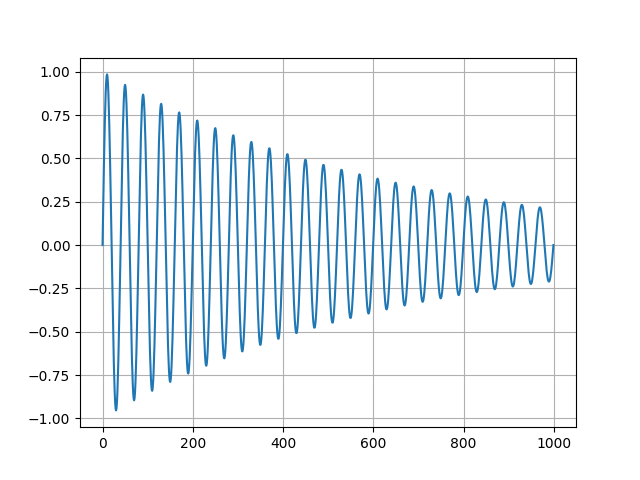

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib widget

x = np.linspace(0, 50*np.pi, 1000)      # ho messo numeri irrazionali perché confondevamo le x variabili con le posizioni (scegliendole intere coincidevano), dunque pensavamo di aver trovato i valori
def fun(x):                             # e non gli indici. Quindi stavamo cercando gli indici tra gli stessi indici già trovati
    return np.sin(x) * np.exp(-x/100)

a = fun(x)

plt.figure()
plt.plot(a)
plt.grid()

fp = find_peaks(a)

print(type(fp))                    # il problema è che fp è una tupla con dentro un array, una roba e un dizionario, non un array
print(fp[0])                       # questo è l'array contenente gli indici dei massimi

index = fp[0]

for i in index:
    print('position: ', i, '   x = ', x[i],  '   f(x) = ', a[i])
    

# x e a sono due array di stessa lunghezza, quindi se find peakes trova le posizioni, basta poi stampare a[fp] e x[fp]
# purché fp venga prima convertito in array



